In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Natural Language Processing Challenge
# ===========================================
# IMPORTACIONES
# =============

import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import tensorflow as tf

from transformers import pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from transformers import BertTokenizer, BertModel


# Reproducibilidad
seed = 29
np.random.seed(seed)


In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/Miniproyecto 3/dataset/training_data.csv"
TEST_PATH = "/content/drive/MyDrive/Miniproyecto 3/dataset/testing_data.csv"
OUTPUT_PATH = "/content/drive/MyDrive/Miniproyecto 3/testing_data_predicted.csv"


In [ ]:
# Cargar los CSV (misma carpeta)

train_df = pd.read_csv(TRAIN_PATH, sep="\t", header=None, names = ["label", "headline"])
test_df = pd.read_csv(TEST_PATH, sep="\t", header=None, names = ["label", "headline"])

# Verificar que cargaron bien
print(f"Training data head:\n{train_df.head()}")
print()
print(f"Testing data head:\n{test_df.head()}")
print()

print(f"Training data info:\n{train_df.info()}")
print()
print(f"Testing data info:\n{test_df.info()}")
print()

Training data head:
   label                                           headline
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...

Testing data head:
  label                                           headline
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     34152 non-null  int64 
 1   headline  34152 no

In [ ]:
# Separar variables
x = train_df["headline"].astype(str)
y = train_df["label"].astype(int).values
x_test = test_df["headline"].astype(str)

In [ ]:
# PREPARACIÓN DE BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# EXTRACCIÓN DE EMBEDDINGS


def get_bert_embeddings(sentences, batch_size=16):
    all_embeddings = []

    with torch.no_grad():
        for i in range(0, len(sentences), batch_size):
            batch = sentences.iloc[i:i+batch_size].tolist()

            inputs = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            )

            outputs = bert_model(**inputs)

            # Embedding del token [CLS]
            cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            all_embeddings.append(cls_embeddings)

    return np.vstack(all_embeddings)

print("Extrayendo embeddings de BERT...")
X_embeddings = get_bert_embeddings(x)


Extrayendo embeddings de BERT...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PREPARACIÓN DE DATOS


# PASO 1: Separar features (X) y target (y)

X = X_embeddings
y = y


# PASO 2: Split train/validation (80/20)
# stratify=y mantiene la proporción de clases

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,        # 20% para validación
    random_state=seed,    # Reproducibilidad
    stratify=y            # Mantener proporción fake/real
)

print(f"Train: {len(X_train)} titulares")
print(f"Validation: {len(X_val)} titulares")
print(f"Total: {len(X)} titulares")
print()


# PASO 3: Estandarización
# ------------------------
# ANN requiere que los datos estén estandarizados (en este enfoque).
# IMPORTANTE: el scaler se ajusta SOLO con train para evitar data leakage.

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  # Fit SOLO en train
X_val_scaled   = scaler.transform(X_val)        # Transform en validation (mismo scaler)



Train: 27321 titulares
Validation: 6831 titulares
Total: 34152 titulares



In [ ]:
# ARQUITECTURA DE LA RED NEURONAL
# ================================
from tensorflow.keras.layers import Input # Importar la capa Input

model = Sequential()

model.add(Input(shape=(768,)))             # Capa de entrada: 768 dimensiones (BERT)

model.add(Dense(32, activation='relu'))   # 32 neuronas, con relu
model.add(Dropout(0.33))                  # Dropout 33%
model.add(Dense(32, activation='relu'))   # 32 neuronas, con relu
model.add(Dropout(0.33))                  # Dropout 33%

model.add(Dense(1, activation='sigmoid'))  # Capa de salida: 1 neurona, sigmoid

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,697 (100.38 KB)

 Trainable params: 25,697 (100.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# COMPILAR Y ENTRENAR MODELO
# ==========================
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer=SGD(learning_rate=0.01),  # SGD con LR=0,01
    loss='binary_crossentropy',         # Loss para clasificación binaria
    metrics=['accuracy'])               # Métrica: accuracy

early_stop = EarlyStopping(
    monitor='val_loss',           # Monitorear loss de validación
    patience=5,                   # Esperar 5 épocas sin mejora
    restore_best_weights=True,    # Restaurar mejores pesos
    verbose=1)                    # Mostrar cuando se detiene

history = model.fit(
    X_train_scaled, y_train,                  # Datos de entrenamiento
    epochs=200,                               # Máximo 200 épocas
    batch_size=6,                             # Batch muy pequeño (pocos datos)
    validation_data=(X_val_scaled, y_val),  # Validar en validation (fixed: use X_val_scaled, y_val)
    callbacks=[early_stop],                   # Aplicar Early Stopping
    shuffle=True,                             # Mezclar datos en cada época
    verbose=1)                                # Mostrar progreso

print("Modelo entrenado!")

Epoch 1/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8766 - loss: 0.2839 - val_accuracy: 0.9445 - val_loss: 0.1394
Epoch 2/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9396 - loss: 0.1554 - val_accuracy: 0.9502 - val_loss: 0.1296
Epoch 3/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9483 - loss: 0.1321 - val_accuracy: 0.9505 - val_loss: 0.1217
Epoch 4/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9546 - loss: 0.1238 - val_accuracy: 0.9532 - val_loss: 0.1161
Epoch 5/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9598 - loss: 0.1092 - val_accuracy: 0.9533 - val_loss: 0.1174
Epoch 6/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9625 - loss: 0.1021 - val_accuracy: 0.9545 - val_loss: 0.1149
Epoch 7/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9630 - loss: 0.0992 - val_accuracy: 0.9573 - val_loss: 0.1103
Epoch 8/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9660 -

F-Beta Score VALIDATION (β=3, FAKE=0):  0.9539
F-Beta Score TRAIN (β=3, FAKE=0):       0.9738

Accuracy VALIDATION: 0.9573
Accuracy TRAIN:      0.9779



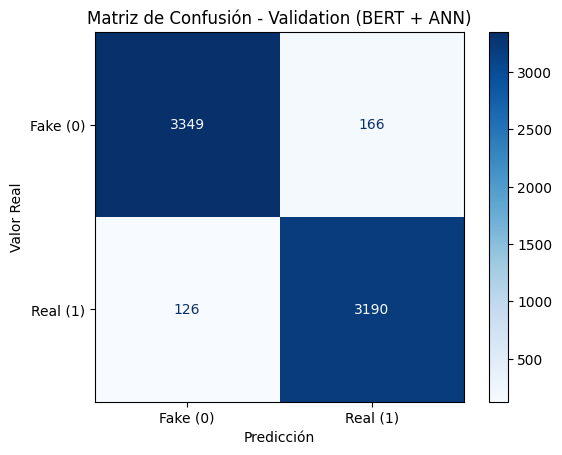

Detalle Matriz de Confusión (Validation):
  Verdaderos Negativos (TN): 3349 - Fake detectada correctamente (0→0)
  Falsos Positivos (FP):     166 - Fake clasificada como Real (0→1) - CRÍTICO
  Falsos Negativos (FN):     126 - Real clasificada como Fake (1→0)
  Verdaderos Positivos (TP): 3190 - Real detectada correctamente (1→1)

Classification Report (Validation):
              precision    recall  f1-score   support

    Fake (0)       0.96      0.95      0.96      3515
    Real (1)       0.95      0.96      0.96      3316

    accuracy                           0.96      6831
   macro avg       0.96      0.96      0.96      6831
weighted avg       0.96      0.96      0.96      6831



In [ ]:
# EVALUAR MODELO
# ==============

from sklearn.metrics import (
    fbeta_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score
)

# Predicciones en VALIDATION (X_val_scaled)
y_val_pred = (model.predict(X_val_scaled, verbose=0) > 0.5).astype(int).flatten()

# Predicciones en TRAIN - chequeo overfitting
y_train_pred = (model.predict(X_train_scaled, verbose=0) > 0.5).astype(int).flatten()


# β=3 priorizo Recall de FAKE (label=0) para no dejar pasar noticias falsas como reales
# -----------------------------------------------------------------------------------
# Nota: fbeta_score por defecto considera la clase positiva como 1.
# Como aquí queremos priorizar la clase 0 (FAKE), usamos pos_label=0.
beta = 3

fbeta_val = fbeta_score(y_val, y_val_pred, beta=beta, pos_label=0)
print(f"F-Beta Score VALIDATION (β={beta}, FAKE=0):  {fbeta_val:.4f}")

fbeta_train = fbeta_score(y_train, y_train_pred, beta=beta, pos_label=0)
print(f"F-Beta Score TRAIN (β={beta}, FAKE=0):       {fbeta_train:.4f}")


# Accuracy (métrica adicional estándar)
acc_val = accuracy_score(y_val, y_val_pred)
acc_train = accuracy_score(y_train, y_train_pred)
print(f"\nAccuracy VALIDATION: {acc_val:.4f}")
print(f"Accuracy TRAIN:      {acc_train:.4f}\n")


# Crear y visualizar matriz de confusión
# --------------------------------------
cm_val = confusion_matrix(y_val, y_val_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["Fake (0)", "Real (1)"])
disp.plot(values_format="d", cmap="Blues")
plt.title("Matriz de Confusión - Validation (BERT + ANN)")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


# Interpretación de la matriz (para el reporte)
# ---------------------------------------------
TN = cm_val[0, 0]  # Fake predicho como Fake
FP = cm_val[0, 1]  # Fake predicho como Real (peligroso: fake pasa como real)
FN = cm_val[1, 0]  # Real predicho como Fake
TP = cm_val[1, 1]  # Real predicho como Real

print("Detalle Matriz de Confusión (Validation):")
print(f"  Verdaderos Negativos (TN): {TN} - Fake detectada correctamente (0→0)")
print(f"  Falsos Positivos (FP):     {FP} - Fake clasificada como Real (0→1) - CRÍTICO")
print(f"  Falsos Negativos (FN):     {FN} - Real clasificada como Fake (1→0)")
print(f"  Verdaderos Positivos (TP): {TP} - Real detectada correctamente (1→1)\n")


# Reporte adicional (opcional pero útil)
# --------------------------------------
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=["Fake (0)", "Real (1)"]))


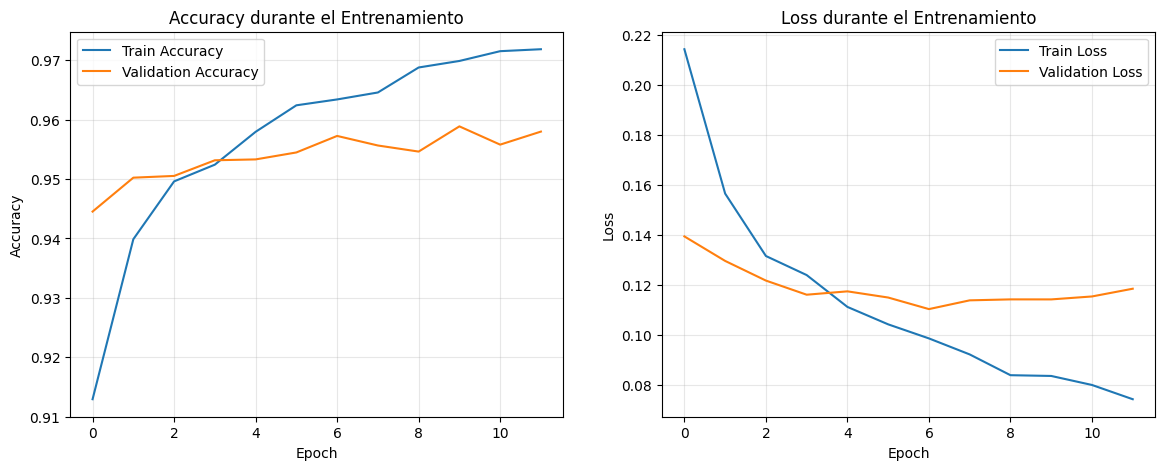

TRAIN:
Loss óptimo: 0.0985
Accuracy óptimo: 96.34%
Loss final: 0.0742
Accuracy final: 97.19%

VALIDATION:
Loss óptimo: 0.1103
Accuracy óptimo: 95.73%
Loss final: 0.1185
Accuracy final: 95.80%


In [ ]:
# VISUALIZACIÓN DE CURVAS DE APRENDIZAJE
# ======================================

# Crear figura con 2 subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy durante el Entrenamiento')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss durante el Entrenamiento')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.show()


best_epoch = np.argmin(history.history['val_loss'])
print(f"TRAIN:")
print(f"Loss óptimo: {history.history['loss'][best_epoch]:.4f}")
print(f"Accuracy óptimo: {history.history['accuracy'][best_epoch]*100:.2f}%")
print(f"Loss final: {history.history['loss'][-1]:.4f}")
print(f"Accuracy final: {history.history['accuracy'][-1]*100:.2f}%")
print()
print(f"VALIDATION:")
print(f"Loss óptimo: {history.history['val_loss'][best_epoch]:.4f}")
print(f"Accuracy óptimo: {history.history['val_accuracy'][best_epoch]*100:.2f}%")
print(f"Loss final: {history.history['val_loss'][-1]:.4f}")
print(f"Accuracy final: {history.history['val_accuracy'][-1]*100:.2f}%")

In [ ]:
# PROBAR EL MODELO CON x_test (testing_data.csv)
# ==============================================

# x_test debe ser: test_df["headline"].astype(str)
# Nota: aquí NO hay y_test real, así que solo podemos predecir, no evaluar.

# Paso 1: Generar embeddings con BERT para x_test
print("Extrayendo embeddings de BERT para x_test...")
X_test = get_bert_embeddings(x_test)

# Paso 2: Estandarizar con el scaler aprendido en train
print("Estandarizando embeddings de x_test...")
X_test_scaled = scaler.transform(X_test)

# Paso 3: Predecir probabilidades y clases
print("Generando predicciones para x_test...")
y_test_prob = model.predict(X_test_scaled, verbose=0).flatten()      # Probabilidad de clase 1 (REAL)
y_test_pred = (y_test_prob > 0.5).astype(int)                       # 0=FAKE, 1=REAL

# Paso 4: Mostrar una muestra de predicciones (10 primeras)
print("\nMUESTRA DE PREDICCIONES (primeras 10):")
for i in range(10):
    titular = x_test.iloc[i] if hasattr(x_test, "iloc") else x_test[i]
    print(f"\nTitular: {titular}")
    print(f"Prob REAL (1): {y_test_prob[i]:.3f} | Predicción: {'REAL (1)' if y_test_pred[i]==1 else 'FAKE (0)'}")

# Paso 5: Distribución de clases predichas (sanity check)
print("\nDistribución de predicciones en x_test:")
unique, counts = np.unique(y_test_pred, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Clase {u} ({'FAKE' if u==0 else 'REAL'}): {c}")

# Paso 6: Generar el archivo final con el mismo formato (tab, sin columnas extra)
output_df = test_df.copy()
output_df["label"] = y_test_pred

output_df.to_csv(
    "predictions_testing_data.csv",
    sep="\t",
    header=False,
    index=False
)

print("\nArchivo 'predictions_testing_data.csv' generado correctamente.")


Extrayendo embeddings de BERT para x_test...
Estandarizando embeddings de x_test...
Generando predicciones para x_test...

MUESTRA DE PREDICCIONES (primeras 10):

Titular: copycat muslim terrorist arrested with assault weapons
Prob REAL (1): 0.193 | Predicción: FAKE (0)

Titular: wow! chicago protester caught on camera admits violent activity was pre-planned: ‚it‚s not gonna be peaceful‚
Prob REAL (1): 0.000 | Predicción: FAKE (0)

Titular: germany's fdp look to fill schaeuble's big shoes
Prob REAL (1): 0.998 | Predicción: REAL (1)

Titular: mi school sends welcome back packet warning kids against wearing u.s. flag to school
Prob REAL (1): 0.029 | Predicción: FAKE (0)

Titular: u.n. seeks 'massive' aid boost amid rohingya 'emergency within an emergency'
Prob REAL (1): 1.000 | Predicción: REAL (1)

Titular: did oprah just leave ‚nasty‚ hillary wishing she wouldn‚t have endorsed her? [video]
Prob REAL (1): 0.000 | Predicción: FAKE (0)

Titular: france's macron says his job not 'cool' cit

In [ ]:
# Asegurar que la carpeta existe
os.makedirs("/content/drive/MyDrive/Miniproyecto 3", exist_ok=True)

# Guardar archivo final
output_df.to_csv(
    OUTPUT_PATH,
    sep="\t",
    header=False,
    index=False
)

print(f"Archivo creado en: {OUTPUT_PATH}")
print(f"\nEstimación de performance (Validation Accuracy): {acc_val*100:.2f}%")


Archivo creado en: /content/drive/MyDrive/Miniproyecto 3/testing_data_predicted.csv

Estimación de performance (Validation Accuracy): 95.73%


In [ ]:
# PORCENTAJES DE FN Y TN
# =====================

# Matriz de confusión:
# [[TN, FP],
#  [FN, TP]]

TN = cm_val[0, 0]
FP = cm_val[0, 1]
FN = cm_val[1, 0]
TP = cm_val[1, 1]

total = TN + FP + FN + TP

# Porcentajes respecto al total
tn_pct = (TN / total) * 100
fn_pct = (FN / total) * 100
fp_pct = (FP / total) * 100
tp_pct = (TP / total) * 100

print("PORCENTAJES SOBRE EL TOTAL DE MUESTRAS (VALIDATION):")
print(f"  TN (Fake → Fake): {tn_pct:.2f}%")
print(f"  FP (Fake → Real): {fp_pct:.2f}%")
print(f"  FN (Real → Fake): {fn_pct:.2f}%")
print(f"  TP (Real → Real): {tp_pct:.2f}%")


PORCENTAJES SOBRE EL TOTAL DE MUESTRAS (VALIDATION):
  TN (Fake → Fake): 49.03%
  FP (Fake → Real): 2.43%
  FN (Real → Fake): 1.84%
  TP (Real → Real): 46.70%


In [ ]:
def mostrar_distribucion(y_labels, nombre):
    total = len(y_labels)
    fake = np.sum(y_labels == 0)
    real = np.sum(y_labels == 1)
    print(f"{nombre}: FAKE={fake} ({fake/total*100:.2f}%) | REAL={real} ({real/total*100:.2f}%)")

mostrar_distribucion(y, "DATASET")
print()
mostrar_distribucion(y_train, "TRAIN")
print()
mostrar_distribucion(y_val, "VALIDATION")



DATASET: FAKE=17572 (51.45%) | REAL=16580 (48.55%)

TRAIN: FAKE=14057 (51.45%) | REAL=13264 (48.55%)

VALIDATION: FAKE=3515 (51.46%) | REAL=3316 (48.54%)
